Different cells for data counting

In [2]:
import glob
import os
import pandas as pd
import numpy as np
from collections import Counter
import csv
import matplotlib.pyplot as plt

Loading the files

In [3]:
method_I_files = sorted(
    glob.glob('//153.19.52.107/emboa/IO3-sessions/NEW STRUCTURE/de-earlyfusionthesis/GUT/*_BORIS_method_I.csv') +
    glob.glob('//153.19.52.107/emboa/IO3-sessions/NEW STRUCTURE/de-earlyfusionthesis/ITU-YU/*_BORIS_method_I.csv') +
    glob.glob('//153.19.52.107/emboa/IO3-sessions/NEW STRUCTURE/de-earlyfusionthesis/MAAP/*_BORIS_method_I.csv')
    )
method_II_files = sorted(
    glob.glob('//153.19.52.107/emboa/IO3-sessions/NEW STRUCTURE/de-earlyfusionthesis/GUT/*_BORIS_method_II.csv') +
    glob.glob('//153.19.52.107/emboa/IO3-sessions/NEW STRUCTURE/de-earlyfusionthesis/ITU-YU/*_BORIS_method_II.csv') +
    glob.glob('//153.19.52.107/emboa/IO3-sessions/NEW STRUCTURE/de-earlyfusionthesis/MAAP/*_BORIS_method_II.csv')
    )
input_files = sorted(
    glob.glob('//153.19.52.107/emboa/IO3-sessions/NEW STRUCTURE/de-earlyfusionthesis/GUT/*_input.csv') + 
    glob.glob('//153.19.52.107/emboa/IO3-sessions/NEW STRUCTURE/de-earlyfusionthesis/ITU-YU/*_input.csv') + 
    glob.glob('//153.19.52.107/emboa/IO3-sessions/NEW STRUCTURE/de-earlyfusionthesis/MAAP/*_input.csv')
    )

This shows the percentage of labels in Method I files

In [4]:
# Initialize a Counter to track label counts
label_counts = Counter()

# Loop through the files and read their labels
for fname in method_I_files:
    with open(fname, 'r') as infile:
        # Assuming labels are one per line
        labels = infile.read().splitlines()
        labels = [label for label in labels if label != '1']  # Exclude label '1'
        label_counts.update(labels)  # Update the Counter with the filtered labels

# Compute the total number of labels
total_labels = sum(label_counts.values())

# Convert the Counter to a DataFrame
df = pd.DataFrame.from_dict(label_counts, orient='index', columns=['Count'])

# Add a new column for percentage
df['Percentage'] = (df['Count'] / total_labels * 100).round(2).astype(str) + '%'  # Format as percentage

# Reset the index to have labels as a column
df = df.reset_index().rename(columns={'index': 'Label'})

# Display the DataFrame
print(df)

       Label  Count Percentage
0       None  43208     83.62%
1      Happy   7692     14.89%
2        Sad    316      0.61%
3  Disgusted     21      0.04%
4  Surprised     47      0.09%
5      Angry     48      0.09%
6     Scared    338      0.65%


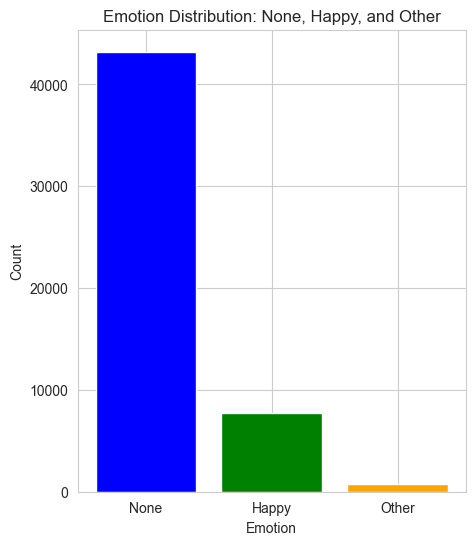

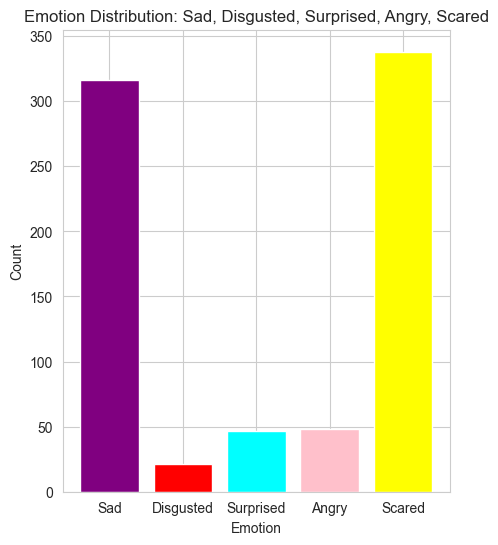

In [11]:
import matplotlib.pyplot as plt

other_count = df[df['Label'].isin(['Sad', 'Disgusted', 'Surprised', 'Angry', 'Scared'])]['Count'].sum()

# Create a new DataFrame for the first plot
df_plot1 = pd.DataFrame({
    'Label': ['None', 'Happy', 'Other'],
    'Count': [df[df['Label'] == 'None']['Count'].values[0],  # Count for 'None'
              df[df['Label'] == 'Happy']['Count'].values[0],  # Count for 'Happy'
              other_count]                                   # Count for 'Other'
})

# Plot for 'None', 'Happy', and 'Other'
plt.figure(figsize=(5, 6))
plt.bar(df_plot1['Label'], df_plot1['Count'], color=['blue', 'green', 'orange'])
plt.title('Emotion Distribution: None, Happy, and Other')
plt.xlabel('Emotion')
plt.ylabel('Count')
plt.show()

# ** Second Plot: Only 'Sad', 'Disgusted', 'Surprised', 'Angry', 'Scared' **
df_plot2 = df[df['Label'].isin(['Sad', 'Disgusted', 'Surprised', 'Angry', 'Scared'])]

# Plot for individual counts of 'Sad', 'Disgusted', 'Surprised', 'Angry', 'Scared'
plt.figure(figsize=(5, 6))
plt.bar(df_plot2['Label'], df_plot2['Count'], color=['purple', 'red', 'cyan', 'pink', 'yellow'])
plt.title('Emotion Distribution: Sad, Disgusted, Surprised, Angry, Scared')
plt.xlabel('Emotion')
plt.ylabel('Count')
plt.show()

This shows the percentage of ANY percent of emotion in Method II files

In [12]:
# Concatenate all the files
dataframes = [pd.read_csv(file, usecols=lambda column: column != 'Second') for file in method_II_files]
combined_df = pd.concat(dataframes, ignore_index=True)

# Calculate the number of rows where each emotion is non-zero
non_zero_counts = (combined_df != 0).sum()  # Counts of non-zero values per column
total_rows = len(combined_df)  # Total number of rows

# Calculate the "Neutral" count (rows where all values are zero)
neutral_count = (combined_df.sum(axis=1) == 0).sum()

# Add the "Neutral" category to the counts
non_zero_counts["Neutral"] = neutral_count

# Convert to percentages
percentages = ((non_zero_counts / total_rows) * 100).round(2).astype(str) + '%'

# Display the percentages
print(percentages)


Happy        32.69%
Sad           3.16%
Scared         2.4%
Disgusted     1.29%
Surprised     1.16%
Angry          1.4%
Neutral      60.76%
dtype: object


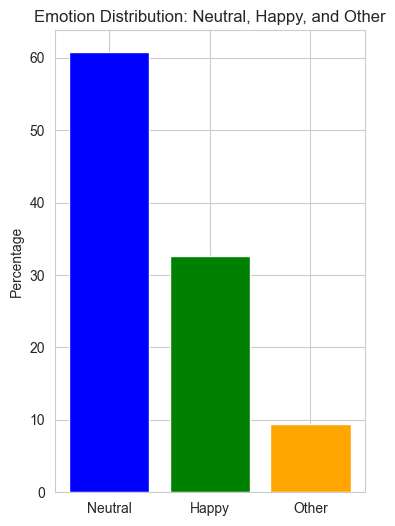

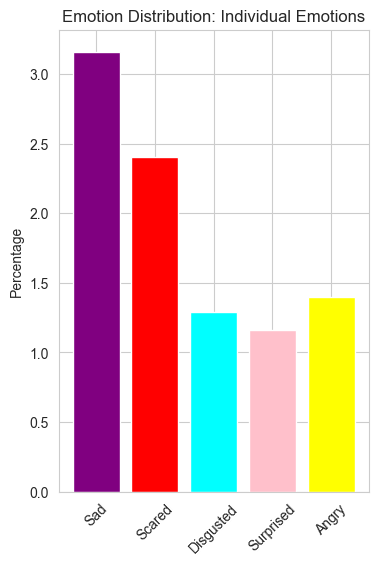

In [16]:
numeric_percentages = percentages.str.rstrip('%').astype(float)

# ** First Plot: Neutral, Happy, and Other (group rest into "Other") **
# Group all emotions except Neutral and Happy into "Other"
main_emotions = ['Neutral', 'Happy']
other_emotions = numeric_percentages.drop(main_emotions).sum()  # Sum of all other emotions

plot1_data = pd.Series({
    'Neutral': numeric_percentages['Neutral'],
    'Happy': numeric_percentages['Happy'],
    'Other': other_emotions
})

# Create the first plot
plt.figure(figsize=(4, 6))  # Thinner plot
plt.bar(plot1_data.index, plot1_data.values, color=['blue', 'green', 'orange'])
plt.title('Emotion Distribution: Neutral, Happy, and Other')
plt.ylabel('Percentage')
plt.show()

# ** Second Plot: Individual emotions (excluding Neutral) **
plot2_data = numeric_percentages.drop(['Neutral', 'Happy'])

# Create the second plot
plt.figure(figsize=(4, 6))  # Thinner plot
plt.bar(plot2_data.index, plot2_data.values, color=['purple', 'red', 'cyan', 'pink', 'yellow'])
plt.title('Emotion Distribution: Individual Emotions')
plt.ylabel('Percentage')
plt.xticks(rotation=45)
plt.show()

This shows how many rows did not manage to extract face embeddings in input files

In [9]:
input_columns = []

# Iterate through the files and extract any of the face embeddings column
for file in input_files:
    df = pd.read_csv(file)  # Read the file
    input_columns.append(df.iloc[:, 4])  # Select any of the columns with face embeddings

# Concatenate all the fifth columns
combined_fifth_column = pd.concat(input_columns, ignore_index=True)

# Calculate total rows
total_rows = len(combined_fifth_column)

# Count zero and non-zero rows
zero_count = (combined_fifth_column == 0).sum()
non_zero_count = (combined_fifth_column != 0).sum()

# Calculate percentages
zero_percentage = (zero_count / total_rows) * 100
non_zero_percentage = (non_zero_count / total_rows) * 100

# Display results
print(f"Percentage of zero rows in face embeddings: {zero_percentage:.2f}%")
print(f"Percentage of non-zero rows: {non_zero_percentage:.2f}%")


Percentage of zero rows in face embeddings: 50.19%
Percentage of non-zero rows: 49.81%


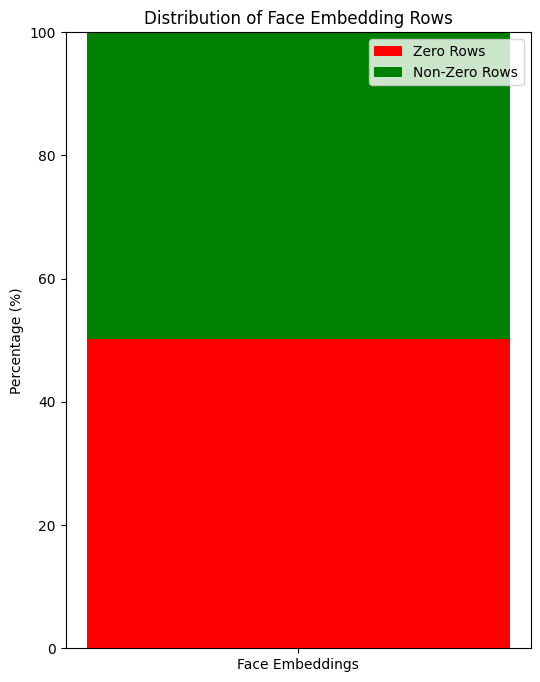

In [16]:
# Data for the bar chart
import matplotlib.pyplot as plt

# Data for the chart
labels = ['Face Embeddings']
data = [zero_percentage, non_zero_percentage]
colors = ['red', 'green']

# Plotting the stacked bar chart
plt.figure(figsize=(6, 8))  # Adjusted size for vertical orientation
plt.bar(labels, data[0], color=colors[0], label='Zero Rows')  # First segment
plt.bar(labels, data[1], bottom=data[0], color=colors[1], label='Non-Zero Rows')  # Second segment stacked on top

# Adding labels, title, and legend
plt.ylabel('Percentage (%)')
plt.title('Distribution of Face Embedding Rows')
plt.legend(loc='upper right')

# Display the chart
plt.ylim(0, 100)  # Ensure the chart spans 0–100%
plt.show()


This makes a comparison of Method I 'null' rows and missing face embeddings

In [72]:
# Ensure that the file lists align correctly
if len(method_I_files) != len(input_files):
    raise ValueError("The number of Method I files and input files do not match!")

# Initialize counters for all four conditions
total_rows = 0
rows_input = 0
count_none_and_zero = 0  # None in Method I and 0 in input
count_none_and_non_zero = 0  # None in Method I and not 0 in input
count_not_none_and_zero = 0  # Not None in Method I but 0 in input
count_not_none_and_non_zero = 0  # Neither None in Method I nor 0 in input

# Iterate through pairs of Method I file and input files
for method_I_file, input_file in zip(method_I_files, input_files):
    # Load Method I data (assuming single-column CSV)
    method_I_df = pd.read_csv(method_I_file, header=None, skiprows=1, names=["Label"])  # Read without column names
    method_I_df["Label"] = method_I_df["Label"].replace("None", np.nan)  # Replace 'None' string with NaN

    # Load input file and select the fifth column
    input_df = pd.read_csv(input_file)
    input_fifth_column = input_df.iloc[:, 4]  # Select the fifth column (index 4)
    # Update the total row count
    total_rows += len(method_I_df)
    rows_input += len(input_df)
    # Boolean masks for the conditions
    is_none = method_I_df["Label"].isna()
    is_zero = input_fifth_column == 0

    # Increment counters for each condition
    count_none_and_zero += (is_none & is_zero).sum()
    count_none_and_non_zero += (is_none & ~is_zero).sum()
    count_not_none_and_zero += (~is_none & is_zero).sum()
    count_not_none_and_non_zero += (~is_none & ~is_zero).sum()

# Calculate percentages for each category
percentage_none_and_zero = (count_none_and_zero / total_rows) * 100
percentage_none_and_non_zero = (count_none_and_non_zero / total_rows) * 100
percentage_not_none_and_zero = (count_not_none_and_zero / total_rows) * 100
percentage_not_none_and_non_zero = (count_not_none_and_non_zero / total_rows) * 100

# Create a 2x2 grid with percentages
grid = pd.DataFrame({
    "Input = 0": [f"{percentage_none_and_zero:.2f}%", f"{percentage_not_none_and_zero:.2f}%"],
    "Input ≠ 0": [f"{percentage_none_and_non_zero:.2f}%", f"{percentage_not_none_and_non_zero:.2f}%"]
}, index=["Method I = None", "Method I ≠ None"])

# Display the grid
print(grid)


                Input = 0 Input ≠ 0
Method I = None    43.18%    40.44%
Method I ≠ None     7.01%     9.37%


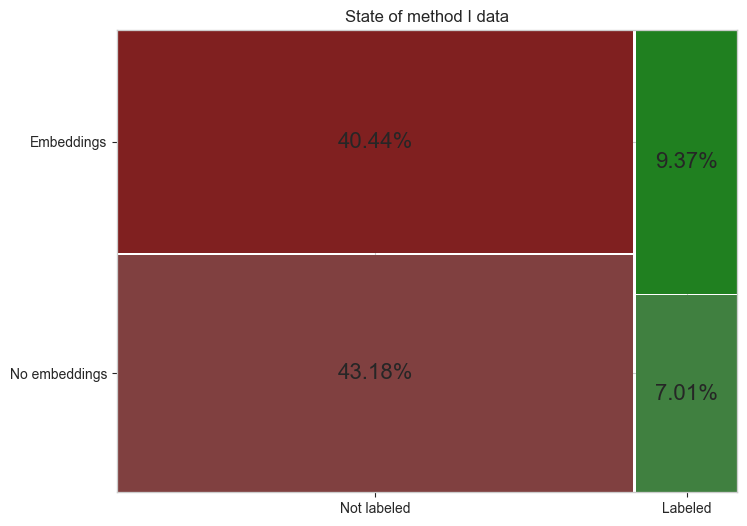

In [28]:
import matplotlib.pyplot as plt
from statsmodels.graphics.mosaicplot import mosaic
import numpy as np

# Data
data = {
    ('Not labeled', 'No embeddings'): 43.18,
    ('Not labeled', 'Embeddings'): 40.44,
    ('Labeled', 'No embeddings'): 7.01,
    ('Labeled', 'Embeddings'): 9.37
}

# Calculate the total sum of the values to compute percentages
total = sum(data.values())

# Function to calculate percentage for each category
def percentage_label(value):
    return f"{(value / total * 100):.2f}%"  # Format the percentage with two decimals

# Create the mosaic plot with the labelizer using the calculated percentages
fig, ax = plt.subplots(figsize=(8, 6))

# Plot the mosaic, applying the labelizer function for percentage labels
mosaic(data, ax=ax, title="State of method I data", 
       labelizer=lambda key: percentage_label(data[key]))

for text in ax.texts:
    text.set_fontsize(16)  # Set the font size for percentage labels here

# Show plot
plt.show()


This makes a comparison of Method II 'empty' rows and missing face embeddings

In [29]:
# Ensure file alignment
if len(method_II_files) != len(input_files):
    raise ValueError("The number of Method II files and input files do not match!")

# Initialize counters
total_rows = 0
count_all_zeros_and_zero = 0  # All zeros in Method II and 0 in input
count_all_zeros_and_non_zero = 0  # All zeros in Method II and not 0 in input
count_non_zeros_and_zero = 0  # Not all zeros in Method II but 0 in input
count_non_zeros_and_non_zero = 0  # Neither all zeros in Method II nor 0 in input

# Process Method II and input files
for method_II_file, input_file in zip(method_II_files, input_files):
    # Load Method II data and ignore the 'Second' column
    method_II_df = pd.read_csv(method_II_file, usecols=lambda col: col != "Second")
    method_II_is_all_zeros = (method_II_df.sum(axis=1) == 0)  # Check for rows with all zeros

    # Load Input file and select the fifth column
    input_df = pd.read_csv(input_file)
    input_fifth_column = input_df.iloc[:, 4]  # Select the fifth column (index 4)

    # Ensure row count alignment
    if len(method_II_df) != len(input_fifth_column):
        raise ValueError(f"Row count mismatch between {method_II_file} and {input_file}")

    # Update total row count
    total_rows += len(method_II_df)

    # Boolean masks for the conditions
    is_zero = input_fifth_column == 0

    # Increment counters for each condition
    count_all_zeros_and_zero += (method_II_is_all_zeros & is_zero).sum()
    count_all_zeros_and_non_zero += (method_II_is_all_zeros & ~is_zero).sum()
    count_non_zeros_and_zero += (~method_II_is_all_zeros & is_zero).sum()
    count_non_zeros_and_non_zero += (~method_II_is_all_zeros & ~is_zero).sum()

# Sanity check: Ensure all rows are accounted for
assert (
    count_all_zeros_and_zero +
    count_all_zeros_and_non_zero +
    count_non_zeros_and_zero +
    count_non_zeros_and_non_zero
) == total_rows, "Counts do not sum up to the total number of rows!"

# Calculate percentages for each category
percentage_all_zeros_and_zero = (count_all_zeros_and_zero / total_rows) * 100
percentage_all_zeros_and_non_zero = (count_all_zeros_and_non_zero / total_rows) * 100
percentage_non_zeros_and_zero = (count_non_zeros_and_zero / total_rows) * 100
percentage_non_zeros_and_non_zero = (count_non_zeros_and_non_zero / total_rows) * 100

# Create a 2x2 grid with percentages
grid = pd.DataFrame({
    "Input = 0": [f"{percentage_all_zeros_and_zero:.2f}%", f"{percentage_non_zeros_and_zero:.2f}%"],
    "Input ≠ 0": [f"{percentage_all_zeros_and_non_zero:.2f}%", f"{percentage_non_zeros_and_non_zero:.2f}%"]
}, index=["Method II = All Zeros", "Method II ≠ All Zeros"])

# Display the grid
print(grid)

# Print sanity check
print(f"Total rows: {total_rows}")
print(f"Sum of percentages: {percentage_all_zeros_and_zero + percentage_all_zeros_and_non_zero + percentage_non_zeros_and_zero + percentage_non_zeros_and_non_zero:.2f}%")


                      Input = 0 Input ≠ 0
Method II = All Zeros    32.13%    28.62%
Method II ≠ All Zeros    18.05%    21.19%
Total rows: 51670
Sum of percentages: 100.00%


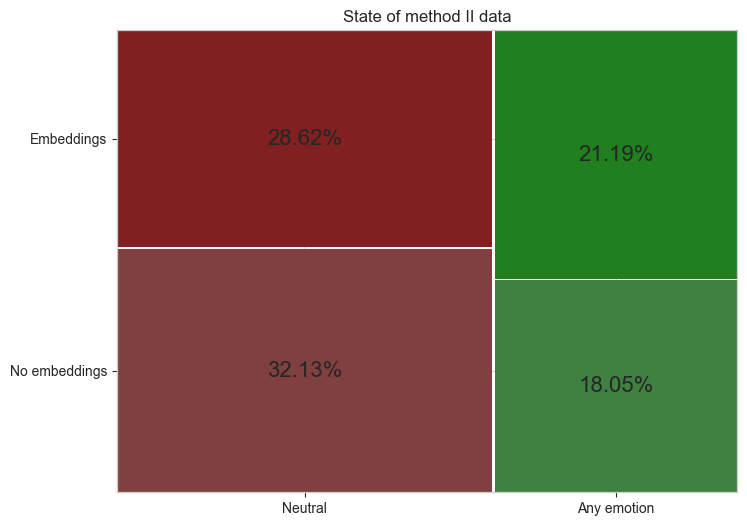

In [30]:
import matplotlib.pyplot as plt
from statsmodels.graphics.mosaicplot import mosaic
import numpy as np

# Data
data = {
    ('Neutral', 'No embeddings'): 32.13,
    ('Neutral', 'Embeddings'): 28.62,
    ('Any emotion', 'No embeddings'): 18.05,
    ('Any emotion', 'Embeddings'): 21.19
}

# Calculate the total sum of the values to compute percentages
total = sum(data.values())

# Function to calculate percentage for each category
def percentage_label(value):
    return f"{(value / total * 100):.2f}%"  # Format the percentage with two decimals

# Create the mosaic plot with the labelizer using the calculated percentages
fig, ax = plt.subplots(figsize=(8, 6))

# Plot the mosaic, applying the labelizer function for percentage labels
mosaic(data, ax=ax, title="State of method II data", 
       labelizer=lambda key: percentage_label(data[key]))

for text in ax.texts:
    text.set_fontsize(16)  # Set the font size for percentage labels here

# Show plot
plt.show()


This one checks if Method I, Method II and input files have the same amount of rows

In [8]:
# Loop through each file and count rows
def count_rows_in_csv(file_path):
    with open(file_path, mode='r') as f:
        reader = csv.reader(f)
        return sum(1 for row in reader)

# Create a list of lists to hold the row counts for each source
row_counts = []

# Count rows for each source and file
for source_files in [method_I_files, method_II_files, input_files]:
    source_row_counts = [count_rows_in_csv(file) for file in source_files]
    row_counts.append(source_row_counts)

# Create DataFrame (3 x number of files)
df = pd.DataFrame(row_counts, columns=[os.path.basename(file) for file in method_I_files])

# Set the index to represent the sources
df.index = ['Source 1', 'Source 2', 'Source 3']

# Show the DataFrame
# Print only columns where the numbers are not the same
# Filter columns where all values are the same
columns_with_diff = df.columns[df.nunique() > 1]

# Display the filtered DataFrame with only columns that have different values
filtered_df = df[columns_with_diff]
pd.set_option('display.max_rows', None)  # Ensure all rows are displayed
pd.set_option('display.max_columns', None)  # Ensure all columns are displayed


# Show the filtered DataFrame
print(filtered_df)

Empty DataFrame
Columns: []
Index: [Source 1, Source 2, Source 3]
